# Test/Dev Neural Network Architecture

In [97]:
from __future__ import print_function

import sys
import os
import time

import numpy as np

import chb
import matplotlib.pyplot as plt
from helpers import *

import pickle

from sklearn.metrics import roc_auc_score, matthews_corrcoef, confusion_matrix

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def metrics(npz, thresh=0.8):
    npzlen = int(len(npz.files)/2)
    for i in range(1, npzlen + 1):
        pred = (npz['_'.join(['prob', str(i)])] > thresh).astype('int32')
        mcc = matthews_corrcoef(npz['_'.join(['true', str(i)])], pred)
        cm = confusion_matrix(npz['_'.join(['true', str(i)])], pred)
        print('Matthews Correlation Coefficient: \t{}'.format(mcc))
        print('Confusion matrix:\n{}'.format(cm))

In [ ]:
init = np.load('./outputs/chb04init.npz', encoding='latin1')
plotprob(init, 0.5)
metrics(init, 0.5)

In [ ]:
chb05 = np.load('./outputs/chb05a5long.npz', encoding='latin1')
print('chb05:',int(len(chb05.files)/2))
chb11 = np.load('./outputs/chb11init.npz', encoding='latin1')
print('chb11:',int(len(chb11.files)/2))
chb17 = np.load('./outputs/chb17init.npz', encoding='latin1')
print('chb17:',int(len(chb17.files)/2))
chb20 = np.load('./outputs/chb20init.npz', encoding='latin1')
print('chb20:',int(len(chb20.files)/2))
chb21 = np.load('./outputs/chb21init.npz', encoding='latin1')
print('chb21:',int(len(chb21.files)/2))
chb22 = np.load('./outputs/chb22init.npz', encoding='latin1')
print('chb22:',int(len(chb22.files)/2))

In [ ]:
plt.figure(figsize=(24,20))
ax1 = plt.subplot(5,6,1)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
            size=20, weight='bold')
plt.plot(chb05['prob_1'])
plt.plot(chb05['true_1'])
plt.subplot(5,6,2)
plt.plot(chb05['prob_2'])
plt.plot(chb05['true_2'])
plt.subplot(5,6,3)
plt.plot(chb05['prob_3'])
plt.plot(chb05['true_3'])
plt.subplot(5,6,4)
plt.plot(chb05['prob_4'])
plt.plot(chb05['true_4'])
plt.subplot(5,6,5)
plt.plot(chb05['prob_5'])
plt.plot(chb05['true_5'])

ax2 = plt.subplot(5,6,7)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
            size=20, weight='bold')
plt.plot(chb11['prob_1'])
plt.plot(chb11['true_1'])
plt.subplot(5,6,8)
plt.plot(chb11['prob_2'])
plt.plot(chb11['true_2'])
plt.subplot(5,6,9)
plt.plot(chb11['prob_3'])
plt.plot(chb11['true_3'])

ax3 = plt.subplot(5,6,13)
ax3.text(-0.1, 1.05, 'C', transform=ax3.transAxes, 
            size=20, weight='bold')
plt.plot(chb20['prob_1'])
plt.plot(chb20['true_1'])
plt.subplot(5,6,14)
plt.plot(chb20['prob_2'])
plt.plot(chb20['true_2'])
plt.subplot(5,6,15)
plt.plot(chb20['prob_4'])
plt.plot(chb20['true_4'])
plt.subplot(5,6,16)
plt.plot(chb20['prob_6'])
plt.plot(chb20['true_6'])
plt.subplot(5,6,17)
plt.plot(chb20['prob_7'])
plt.plot(chb20['true_7'])
plt.subplot(5,6,18)
plt.plot(chb20['prob_8'])
plt.plot(chb20['true_8'])

ax4 = plt.subplot(5,6,19)
ax4.text(-0.1, 1.05, 'D', transform=ax4.transAxes, 
            size=20, weight='bold')
plt.plot(chb21['prob_1'])
plt.plot(chb21['true_1'])
plt.subplot(5,6,20)
plt.plot(chb21['prob_2'])
plt.plot(chb21['true_2'])
plt.subplot(5,6,21)
plt.plot(chb21['prob_3'])
plt.plot(chb21['true_3'])
plt.subplot(5,6,22)
plt.plot(chb21['prob_4'])
plt.plot(chb21['true_4'])

ax5 = plt.subplot(5,6,25)
ax5.text(-0.1, 1.05, 'E', transform=ax5.transAxes, 
            size=20, weight='bold')
plt.plot(chb22['prob_1'])
plt.plot(chb22['true_1'])
plt.subplot(5,6,26)
plt.plot(chb22['prob_2'])
plt.plot(chb22['true_2'])
plt.subplot(5,6,27)
plt.plot(chb22['prob_3'])
plt.plot(chb22['true_3'])

In [ ]:
plt.figure(figsize=(24,20))
ax1 = plt.subplot(5,6,1)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
            size=20, weight='bold')
plt.plot(chb05['prob_1'])
plt.plot(chb05['true_1'])
plt.subplot(5,6,2)
plt.plot(chb05['prob_2'])
plt.plot(chb05['true_2'])
plt.subplot(5,6,3)
plt.plot(chb05['prob_3'])
plt.plot(chb05['true_3'])
plt.subplot(5,6,4)
plt.plot(chb05['prob_4'])
plt.plot(chb05['true_4'])
plt.subplot(5,6,5)
plt.plot(chb05['prob_5'])
plt.plot(chb05['true_5'])

ax2 = plt.subplot(5,6,7)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
            size=20, weight='bold')
plt.plot(chb11['prob_1'])
plt.plot(chb11['true_1'])
plt.subplot(5,6,8)
plt.plot(chb11['prob_2'])
plt.plot(chb11['true_2'])
plt.subplot(5,6,9)
plt.plot(chb11['prob_3'])
plt.plot(chb11['true_3'])

ax5 = plt.subplot(5,6,10)
ax5.text(-0.1, 1.05, 'C', transform=ax5.transAxes, 
            size=20, weight='bold')
plt.plot(chb22['prob_1'])
plt.plot(chb22['true_1'])
plt.subplot(5,6,11)
plt.plot(chb22['prob_2'])
plt.plot(chb22['true_2'])
plt.subplot(5,6,12)
plt.plot(chb22['prob_3'])
plt.plot(chb22['true_3'])

ax3 = plt.subplot(5,6,13)
ax3.text(-0.1, 1.05, 'D', transform=ax3.transAxes, 
            size=20, weight='bold')
plt.plot(chb20['prob_1'])
plt.plot(chb20['true_1'])
plt.subplot(5,6,14)
plt.plot(chb20['prob_2'])
plt.plot(chb20['true_2'])
plt.subplot(5,6,15)
plt.plot(chb20['prob_4'])
plt.plot(chb20['true_4'])
plt.subplot(5,6,16)
plt.plot(chb20['prob_6'])
plt.plot(chb20['true_6'])
plt.subplot(5,6,17)
plt.plot(chb20['prob_7'])
plt.plot(chb20['true_7'])
plt.subplot(5,6,18)
plt.plot(chb20['prob_8'])
plt.plot(chb20['true_8'])

ax4 = plt.subplot(5,6,19)
ax4.text(-0.1, 1.05, 'E', transform=ax4.transAxes, 
            size=20, weight='bold')
plt.plot(chb21['prob_1'])
plt.plot(chb21['true_1'])
plt.subplot(5,6,20)
plt.plot(chb21['prob_2'])
plt.plot(chb21['true_2'])
plt.subplot(5,6,21)
plt.plot(chb21['prob_3'])
plt.plot(chb21['true_3'])
plt.subplot(5,6,22)
plt.plot(chb21['prob_4'])
plt.plot(chb21['true_4'])

The figure above includes the subjects for which a first pass with the ConvNet produced favorable results. The subjects are CHB05, CHB11, CHB20, CHB21, and CHB22. The columns show the output of the ConvNet tested on the seizure file, trained on all others (Leave-One-Out testing). For CHB20, the better of the outputs was chosen for each file that contains two seizures, though they were comparable.

In [ ]:
chb01 = np.load('./outputs/chb01us.npz', encoding='latin1')
print('chb01:',int(len(chb01.files)/2))
chb03 = np.load('./outputs/chb03init.npz', encoding='latin1')
print('chb03:',int(len(chb03.files)/2))
chb07 = np.load('./outputs/chb07init.npz', encoding='latin1')
print('chb07:',int(len(chb07.files)/2))
chb08 = np.load('./outputs/chb08init.npz', encoding='latin1')
print('chb08:',int(len(chb08.files)/2))
chb17 = np.load('./outputs/chb17init.npz', encoding='latin1')
print('chb17:',int(len(chb17.files)/2))
chb18 = np.load('./outputs/chb18init.npz', encoding='latin1')
print('chb18:',int(len(chb18.files)/2))
chb19 = np.load('./outputs/chb19init.npz', encoding='latin1')
print('chb19:',int(len(chb19.files)/2))

In [ ]:
plt.figure(figsize=(24,24))
ax1 = plt.subplot(7,7,1)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
            size=20, weight='bold')
plt.plot(chb01['prob_1'])
plt.plot(chb01['true_1'])
plt.subplot(7,7,2)
plt.plot(chb01['prob_2'])
plt.plot(chb01['true_2'])
plt.subplot(7,7,3)
plt.plot(chb01['prob_3'])
plt.plot(chb01['true_3'])
plt.subplot(7,7,4)
plt.plot(chb01['prob_4'])
plt.plot(chb01['true_4'])
plt.subplot(7,7,5)
plt.plot(chb01['prob_5'])
plt.plot(chb01['true_5'])
plt.subplot(7,7,6)
plt.plot(chb01['prob_6'])
plt.plot(chb01['true_6'])
plt.subplot(7,7,7)
plt.plot(chb01['prob_7'])
plt.plot(chb01['true_7'])

ax2 = plt.subplot(7,7,8)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
            size=20, weight='bold')
plt.plot(chb03['prob_1'])
plt.plot(chb03['true_1'])
plt.subplot(7,7,9)
plt.plot(chb03['prob_2'])
plt.plot(chb03['true_2'])
plt.subplot(7,7,10)
plt.plot(chb03['prob_3'])
plt.plot(chb03['true_3'])
plt.subplot(7,7,11)
plt.plot(chb03['prob_4'])
plt.plot(chb03['true_4'])
plt.subplot(7,7,12)
plt.plot(chb03['prob_5'])
plt.plot(chb03['true_5'])
plt.subplot(7,7,13)
plt.plot(chb03['prob_6'])
plt.plot(chb03['true_6'])
plt.subplot(7,7,14)
plt.plot(chb03['prob_7'])
plt.plot(chb03['true_7'])

ax3 = plt.subplot(7,7,15)
ax3.text(-0.1, 1.05, 'C', transform=ax3.transAxes, 
            size=20, weight='bold')
plt.plot(chb07['prob_1'])
plt.plot(chb07['true_1'])
plt.subplot(7,7,16)
plt.plot(chb07['prob_2'])
plt.plot(chb07['true_2'])
plt.subplot(7,7,17)
plt.plot(chb07['prob_3'])
plt.plot(chb07['true_3'])

ax4 = plt.subplot(7,7,22)
ax4.text(-0.1, 1.05, 'D', transform=ax4.transAxes, 
            size=20, weight='bold')
plt.plot(chb08['prob_1'])
plt.plot(chb08['true_1'])
plt.subplot(7,7,23)
plt.plot(chb08['prob_2'])
plt.plot(chb08['true_2'])
plt.subplot(7,7,24)
plt.plot(chb08['prob_3'])
plt.plot(chb08['true_3'])
plt.subplot(7,7,25)
plt.plot(chb08['prob_4'])
plt.plot(chb08['true_4'])
plt.subplot(7,7,26)
plt.plot(chb08['prob_5'])
plt.plot(chb08['true_5'])

ax5 = plt.subplot(7,7,29)
ax5.text(-0.1, 1.05, 'E', transform=ax5.transAxes, 
            size=20, weight='bold')
plt.plot(chb17['prob_1'])
plt.plot(chb17['true_1'])
plt.subplot(7,7,30)
plt.plot(chb17['prob_2'])
plt.plot(chb17['true_2'])
plt.subplot(7,7,31)
plt.plot(chb17['prob_3'])
plt.plot(chb17['true_3'])

ax6 = plt.subplot(7,7,36)
ax6.text(-0.1, 1.05, 'F', transform=ax6.transAxes, 
            size=20, weight='bold')
plt.plot(chb18['prob_1'])
plt.plot(chb18['true_1'])
plt.subplot(7,7,37)
plt.plot(chb18['prob_2'])
plt.plot(chb18['true_2'])
plt.subplot(7,7,38)
plt.plot(chb18['prob_3'])
plt.plot(chb18['true_3'])
plt.subplot(7,7,39)
plt.plot(chb18['prob_4'])
plt.plot(chb18['true_4'])
plt.subplot(7,7,40)
plt.plot(chb18['prob_5'])
plt.plot(chb18['true_5'])
plt.subplot(7,7,41)
plt.plot(chb18['prob_6'])
plt.plot(chb18['true_6'])

ax7 = plt.subplot(7,7,43)
ax7.text(-0.1, 1.05, 'G', transform=ax7.transAxes, 
            size=20, weight='bold')
plt.plot(chb19['prob_1'])
plt.plot(chb19['true_1'])
plt.subplot(7,7,44)
plt.plot(chb19['prob_2'])
plt.plot(chb19['true_2'])
plt.subplot(7,7,45)
plt.plot(chb19['prob_3'])
plt.plot(chb19['true_3'])

In [ ]:
chb02 = np.load('./outputs/chb02init.npz', encoding='latin1')
print('chb02:',int(len(chb02.files)/2))
chb04 = np.load('./outputs/chb04init.npz', encoding='latin1')
print('chb04:',int(len(chb04.files)/2))
chb09 = np.load('./outputs/chb09us3.npz', encoding='latin1')
print('chb09:',int(len(chb09.files)/2))

In [ ]:
plt.figure(figsize=(16,12))
ax1 = plt.subplot(3,4,1)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, 
            size=20, weight='bold')
plt.plot(chb02['prob_1'])
plt.plot(chb02['true_1'])
plt.subplot(3,4,2)
plt.plot(chb02['prob_2'])
plt.plot(chb02['true_2'])


ax2 = plt.subplot(3,4,5)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, 
            size=20, weight='bold')
plt.plot(chb04['prob_1'])
plt.plot(chb04['true_1'])
plt.subplot(3,4,6)
plt.plot(chb04['prob_2'])
plt.plot(chb04['true_2'])
plt.subplot(3,4,7)
plt.plot(chb04['prob_3'])
plt.plot(chb04['true_3'])
plt.subplot(3,4,8)
plt.plot(chb04['prob_4'])
plt.plot(chb04['true_4'])


ax3 = plt.subplot(3,4,9)
ax3.text(-0.1, 1.05, 'C', transform=ax3.transAxes, 
            size=20, weight='bold')
plt.plot(chb09['prob_1'])
plt.plot(chb09['true_1'])
plt.subplot(3,4,10)
plt.plot(chb09['prob_2'])
plt.plot(chb09['true_2'])
plt.subplot(3,4,11)
plt.plot(chb09['prob_3'])
plt.plot(chb09['true_3'])
plt.subplot(3,4,12)
plt.plot(chb09['prob_4'])
plt.plot(chb09['true_4'])

In [ ]:
chb10 = np.load('./outputs/chb10init.npz', encoding='latin1')

In [ ]:
plotprob(chb10)

In [16]:
b = 0.9
a = 0.55
d = 7
c = 3

In [17]:
x = np.random.random_sample((5,2))
x[:,0] = (x[:,0] * (d - c)).astype('int') + c
x[:,1] = (x[:,1] * (b - a)) + a

In [18]:
x

array([[ 6.        ,  0.80735164],
       [ 6.        ,  0.77955195],
       [ 4.        ,  0.70136478],
       [ 4.        ,  0.5897232 ],
       [ 5.        ,  0.86899042]])

In [ ]:
def to_s(hz):
    if type(hz) is int:
        return int(hz / 256)
    elif type(hz) is list:
        return [int(hz / 256) for f in hz]
    elif type(hz) is np.ndarray:
        return hz / 256

In [ ]:
def szr_pc(subj, osr=1, usp=0):
    total, seizure = 0, 0
    for file_, (start, stop) in subj.get_ict():
        total += to_s(subj.get_file(file_).get_rec().shape[1])
        seizure += (stop - start)
    return ((seizure * osr)/(total * (1 - usp))) * 100

In [ ]:
subj = chb.load_dataset('chb22')

In [ ]:
szr_pc(subj)

In [ ]:
szr_pc(subj, 4)

In [ ]:
szr_pc(subj, 5, 0.8)

## Over/Under-Sampling Tests
We'll start with CHB05 and see where it goes.

In [104]:
chb05samp = [
    {'osr':6,'usp':0.97279509,
     'mcc':[0.659999112736,0.614910581808,0.655943125903,
            0.506662167418,0.500317761252],},
    {'osr':5,'usp':0.47548674,
     'mcc':[0.969956264552,0.842557962875,0.920803042474,
            0.906016461937,0.868044450703],},
    {'osr':6,'usp':0.26039901,
     'mcc':[0.98265522272,0.908193284061,0.90419660998,
            0.953574779815,0.884798433933],},
    {'osr':3,'usp':0.48998689,
     'mcc':[0.900923183936,0.845642228485,0.837171076377,
            0.82944341319,0.783161804566],},
    {'osr':4,'usp':0.5038716,
     'mcc':[0.956052875517,0.891476173092,0.857239169232,
            0.902443951583,0.886472984383],},
    {'osr':4,'usp':0.94076041,
     'mcc':[0.47632604846,0.844831609322,0.767630941835,
            0.666575634304,0.461869741583],},
    {'osr':4,'usp':0.062816,
     'mcc':[0.937978274747,0.925710767293,0.89298785734,
            0.897902613369,0.850119851039],},
    {'osr':3,'usp':0.03713701,
     'mcc':[0.951574389245,0.851138249725,0.882438451142,
            0.839085440091,0.834127849656],},
    {'osr':6,'usp':0.07069546,
     'mcc':[0.982626864866,0.86264330942,0.878559279148,
            0.912645969338,0.87848555481],},
    {'osr':6,'usp':0.12884357,
     'mcc':[0.98265522272,0.882907362926,0.898613342349,
            0.949626965984,0.843308699813],},
    {'osr':6,'usp':0.80735164,
     'mcc':[0.978267974817,0.883454955739,0.842866039079,
            0.861357222136,0.669871111545],},
    {'osr':6,'usp':0.77955195,
     'mcc':[0.94922971041,0.853602733604,0.842228813801,
            0.845520890415,0.717656601298],},
    {'osr':4,'usp':0.70136578,
     'mcc':[0.96105771516,0.865389383721,0.904608036566,
               0.851883199229,0.843731087928],},
    {'osr':4,'usp':0.5897232,
     'mcc':[0.924206119349,0.863215160264,0.92119949898,
               0.914644984476,0.878304359492],},
    {'osr':5,'usp':0.86899052,
     'mcc':[0.947890131362,0.861161964696,0.860529878124,
               0.759298855846,0.722659528579],},
]
pickle.dump(chb05samp, open('chb05samptest.p', 'wb'))

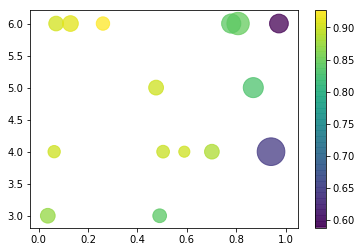

In [91]:
osr5 = [test['osr'] for test in chb05samp]
usp5 = [test['usp'] for test in chb05samp]
mcc5 = [np.mean(test['mcc']) for test in chb05samp]
mccstd5 = [np.std(test['mcc']) for test in chb05samp]
#pc5 = [szr_pc(chb05, test['osr'], test['usp']) for test in chb05samp]
pc5 = [7.055728704718547,
 0.30496601807595364,
 0.2595324600583415,
 0.18818189241869177,
 0.25793116512618486,
 2.1601597219729216,
 0.13654413249072742,
 0.09967693555044878,
 0.20655281033737857,
 0.22033983540279306,
 0.996377360265537,
 0.8707287925490147,
 0.42850741038381307,
 0.311904003015013,
 1.2209705765585614]
plt.figure()
plt.scatter(usp5, osr5, c=mcc5, s=[x * 5e3 for x in mccstd5], alpha=0.75)
plt.colorbar()


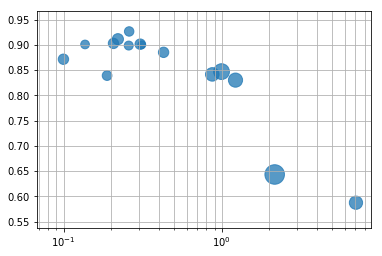

In [93]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(pc5, mcc5, marker='o', s=[x * 2.5e3 for x in mccstd5], alpha=0.75)
ax.set_xscale('log')
ax.grid(which='both')

In [105]:
chb20samp = [
    {'osr':6, 'usp':0.96988346, # 0
     'mcc':[0.540981395854,0.550597785421,0.583310067086,0.664255601999,
            0.634548314526,0.648648917826,0.223008514099,0.292356620175]},
    {'osr':3,'usp':0.81363392, # 1
     'mcc':[0.589577603986,0.540547876974,0.389502944467,0.79827947514,
            0.64131006571,0.726877785138,0.158888533912,0.267040367705]},
    {'osr':6,'usp':0.28452097, # 2
     'mcc':[0.631884059957,0.760272655978,0.613333568976,0.717049293983,
            0.685880773635,0.712019263772,0.133219188553,0.137618599407]},
    {'osr':4,'usp':0.24318379, # 3
     'mcc':[0.694849081382,0.495048250196,0.547410571674,0.750039913673,
            0.607695279201,0.643797130572,0.142081403616,0.119331724335]},
    {'osr':6,'usp':0.51591069, # 4
     'mcc':[0.577001449321,0.616240387826,0.6117231674,0.744095685134,
            0.658142808676,0.761161468547,0.125941959887,0.125578365389]},
    {'osr':5,'usp':0.22879187, # 5
     'mcc':[0.602243717881,0.62001643421,0.489670168165,0.781510960476,
            0.718932207016,0.755550523156,0.0904215193316,0.168258746655]},
    {'osr':4,'usp':0.4071291, # 6
     'mcc':[0.644432611671,0.511115226111,0.597874842817,0.670633681107,
            0.629306464667,0.688842074547,0.261594879009,0.0722908749906]},
    {'osr':6,'usp':0.48395341, # 7
     'mcc':[0.707159741239,0.615530173098,0.592383765155,0.750850083884,
            0.729271365135,0.751458043599,0.105516090237,0.175504555889]},
    {'osr':5,'usp':0.22309933, # 8
     'mcc':[0.591119766177,0.51694229868,0.591461839239,0.750039913673,
            0.717417266896,0.724091015851,0.160966425332,0.0889393411994]},
    {'osr':4,'usp':0.24176802, # 9
     'mcc':[0.60938907833,0.548135452131,0.522164715784,0.773504194913,
            0.68284341005,0.725539964439,0.202737166817,0.0472655725333]},
]
pickle.dump(chb20samp, open('chb20samptest.p', 'wb'))

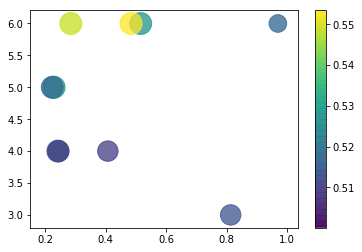

In [92]:
osr20 = [test['osr'] for test in chb20samp]
usp20 = [test['usp'] for test in chb20samp]
mcc20 = [np.mean(test['mcc']) for test in chb20samp]
mccstd20 = [np.std(test['mcc']) for test in chb20samp]
#pc20 = [szr_pc(chb20, test['osr'], test['usp']) for test in chb20samp]
pc20 = [2.174020692439478,
 0.17565959734915595,
 0.09151069199705428,
 0.05767492845207528,
 0.13525186322474497,
 0.07074828289725237,
 0.0736236518997994,
 0.12687610462590437,
 0.0702298930362629,
 0.05756723788295078]
plt.figure()
plt.scatter(usp20, osr20, c=mcc20, s=[x * 2e3 for x in mccstd20], alpha=0.75)
plt.colorbar()


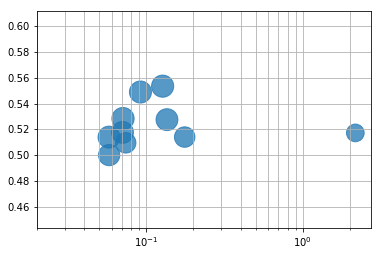

In [94]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(pc20, mcc20, marker='o', s=[x * 2e3 for x in mccstd20], alpha=0.75)
ax.set_xscale('log')
ax.grid(which='both')

In [106]:
chb21samp = [
    {'osr':4,
     'usp':0.67562778,
     'mcc':[0.356854570228, 0.263567586074, 0.151792803992, 0.305683281437],},
    {'osr':4,
     'usp':0.68228429,
     'mcc':[0.19197466619,0.538383885762,0.473577128062,0.130946740528],},
    {'osr':6,
     'usp':0.58934185,
     'mcc':[0.406755465986,0.406071246179,0.295065503694,0.468073566392],},
    {'osr':5,
     'usp':0.78269928,
     'mcc':[0.348710483264,0.130373894333,0.257524108779,0.286508455002],},
    {'osr':4,
     'usp':0.30917857,
     'mcc':[0.268043052858,0.389284838944,0.501311804467,0.256095257032],},
    {'osr':5,
     'usp':0.35367979,
     'mcc':[0.268043052858,0.233032441664,0.663775611999,0.198495797899],},
    {'osr':3,
     'usp':0.76457202,
     'mcc':[0.168474142468,0.355276215107,0.462126607892,0.185523524593],},
    {'osr':4,
     'usp':0.53239368,
     'mcc':[0.156637343639,0.386873765009,0.271673745244,0.340939551797],},
    {'osr':6,
     'usp':0.2474348,
     'mcc':[0.382682676333,0.525657383421,0.43778602586,0.386426886372],},
    {'osr':6,
     'usp':0.28549516,
     'mcc':[0.365808453647,0.545538550192,0.417255024943,0.299600636954],},
]
pickle.dump(chb21samp, open('chb21samptest.p', 'wb'))

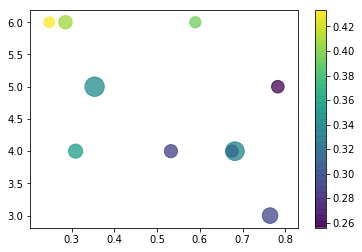

In [95]:
osr21 = [test['osr'] for test in chb21samp]
usp21 = [test['usp'] for test in chb21samp]
mcc21 = [np.mean(test['mcc']) for test in chb21samp]
mccstd21 = [np.std(test['mcc']) for test in chb21samp]
#pc21 = [szr_pc(chb21, test['osr'], test['usp']) for test in chb21samp]
pc21 = [0.1805585265981609,
 0.184341435658232,
 0.21393038265248535,
 0.3369073634027449,
 0.08478047664585985,
 0.11327235557235339,
 0.18657989413336035,
 0.12525102336635335,
 0.11673706832160421,
 0.12295543745912449]
plt.figure()
plt.scatter(usp21, osr21, c=mcc21, s=[x * 2e3 for x in mccstd21], alpha=0.75)
plt.colorbar()


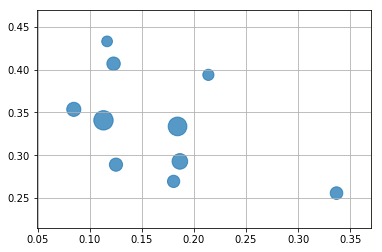

In [96]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(pc21, mcc21, marker='o', s=[x * 2e3 for x in mccstd21], alpha=0.75)
#ax.set_xscale('log')
ax.grid(which='both')